In [1]:
from src.simulation_utils import *

In [2]:
mug_inds = [130]
mug_poses = [[-0.1,0.4,1.2,1,0,0,.0]]

S = Simulation("world3.g", mug_inds, mug_poses)
C = Configuration("world3.g", exp_name='PIFO_best', mug_inds=mug_inds)

/home/jung-su/miniconda3/envs/torchSource/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


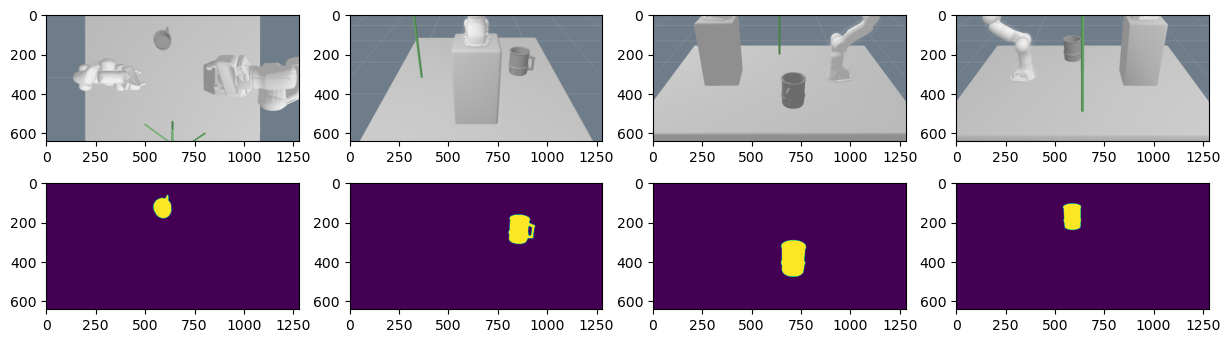

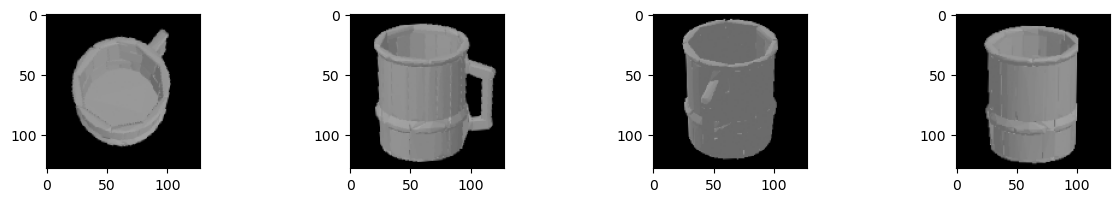

In [ ]:
C.setJointState(S.get_q())
out = S.takePicture(mug_inds)
C.updatePIFO(mug_inds, *out[2:])
Skeleton = [["grasp", "R_", mug_inds[0]], 
            ["grasp", "L_", mug_inds[0]],
            ["hang", "U_", mug_inds[0]]
           ]
traj, komo = C.solveKOMO(Skeleton)
V = komo.view()

In [7]:
V.playVideo(2.)

True

In [5]:
S = Simulation("world3.g", mug_inds, mug_poses, 1)
S.executeTrajectory(traj[:10])
grasped = S.closeGripper(mug_inds[0], "R_")
S.executeTrajectory(traj[10:20])
grasped = S.closeGripper(mug_inds[0], "L_")
S.openGripper("R_")
S.executeTrajectory(traj[20:])
S.openGripper("L_")
S.stepNone(.3)
S.goingBack(1.)
S.stepNone(1.)

In [6]:
# t = 0
# save_dir = 'screenshots/handover/'

# S = Simulation("world3.g", mug_inds, mug_poses, 1)
# input()

# for i in range(10):
#     S.executeTrajectory(traj[i:i+1])
#     plt.imsave(save_dir+str(t).zfill(3)+'.png', S.S.getScreenshot()[::-1])
#     t += 1
# grasped = S.closeGripper(mug_inds[0], "R_")
# plt.imsave(save_dir+str(t).zfill(3)+'.png', S.S.getScreenshot()[::-1])
# t += 1
# for i in range(10,20):
#     S.executeTrajectory(traj[i:i+1])
#     plt.imsave(save_dir+str(t).zfill(3)+'.png', S.S.getScreenshot()[::-1])
#     t += 1
# grasped = S.closeGripper(mug_inds[0], "L_")
# plt.imsave(save_dir+str(t).zfill(3)+'.png', S.S.getScreenshot()[::-1])
# t += 1
# S.openGripper("R_")
# for i in range(20,30):
#     S.executeTrajectory(traj[i:i+1])
#     plt.imsave(save_dir+str(t).zfill(3)+'.png', S.S.getScreenshot()[::-1])
#     t += 1
# S.openGripper("L_")
# for i in range(3):
#     S.stepNone(0.1)
#     plt.imsave(save_dir+str(t).zfill(3)+'.png', S.S.getScreenshot()[::-1])
#     t += 1
# S.stepNone(.3)
# dq = S.qInit - S.get_q()
# for i in range(10):
#     S.stepPosition(S.get_q()+dq/10, 0.1)
#     plt.imsave(save_dir+str(t).zfill(3)+'.png', S.S.getScreenshot()[::-1])
#     t += 1

In [7]:

# for i in range(10):
#     S.stepNone(0.1)
#     plt.imsave(save_dir+str(t).zfill(3)+'.png', S.S.getScreenshot()[::-1])
#     t += 1

In [8]:
# os.system('ffmpeg -r 5 -pattern_type glob -i \'screenshots/handover/*.png\' -c:v libx264 videos/handover.mp4')

0

In [ ]:
import os
from os import path
import h5py
import time
import sys

sys.path.append('../../../rai-fork/rai/ry')
import libry as ry
import numpy as np
import matplotlib.pyplot as plt
from src.simulation_utils import *

import torch
from src.frame import Frame
from src.feature import KeyPoint_Feature, JIT_Collision_Feature, JIT_Keypoint_Feature
from src.utils import *

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
exp_name = 'PIFO_best'
state = torch.load('network/'+exp_name+'.pth.tar')

config = state['config']

# Model
obj = Frame()
obj.build_backbone(pretrained=True, **config)
obj.build_sdf_head(config['SDF_HEAD_HIDDEN'])
obj.build_keypoint_head('grasp', config['GRASP_HEAD_HIDDEN'], config['GRIPPER_POINTS'])
obj.build_keypoint_head('hang', config['HANG_HEAD_HIDDEN'], config['HOOK_POINTS'])
obj.load_state_dict(state['network'])
obj.to(device).eval()
print('1')
F_grasp = KeyPoint_Feature(obj, 'grasp')
F_hang = KeyPoint_Feature(obj, 'hang')

cuda
1


0.1447187123516215
[-0.10054825  0.39886827  0.94658218] 0.1447187123516215


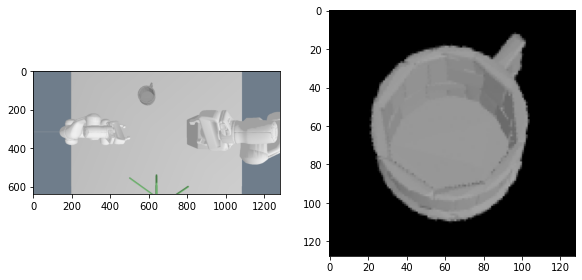

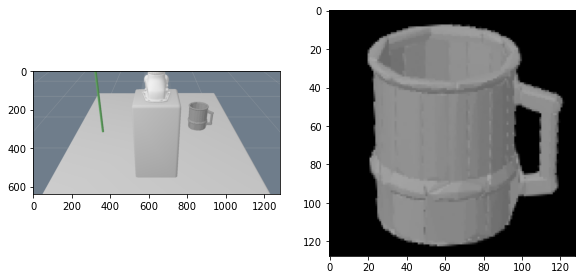

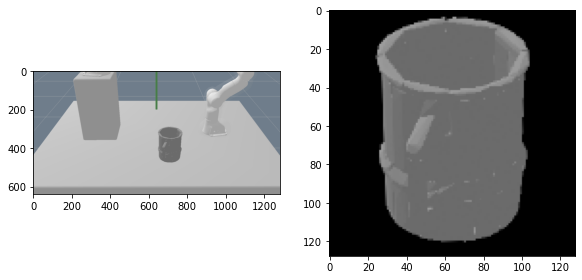

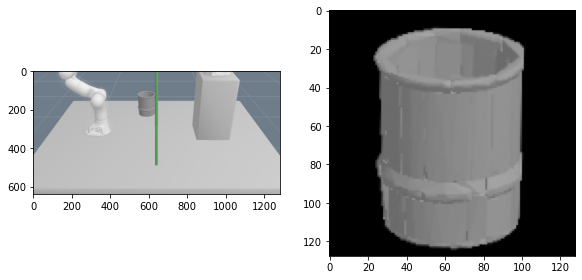

[ 0.00177134 -0.00245581 -0.01522967] 0.01552777069821598 0.002905907301751802


In [33]:
load_dir = '../dataGeneration_vF/data/object'
ind = 130

filename = [fn for fn in os.listdir(load_dir) if fn.endswith('.hdf5')][ind]
    
data_obj = h5py.File(path.join(load_dir, filename), mode='r')
filename = data_obj['filename'][()].decode()
mesh_coll_name = path.join('data/meshes_coll', filename)
size = data_obj['size'][()]
print(size)
mass = data_obj['mass'][()]
com = data_obj['com'][:]
data_obj.close()


camera_name_list = ['camera_'+str(i) for i in range(4)]


RealWorld = ry.Config()
RealWorld.addFile('world3.g')
mug = RealWorld.addMeshFrame(mesh_coll_name, 'mug', mass=mass, com=com)
mug.setPosition([-0.1,0.4,1.2]).setQuaternion([1,0,0,.0])
RealWorld.selectJoints([j for j in RealWorld.getJointNames() if j not in ['R_L_finger', 'L_L_finger']])

camera = RealWorld.cameraView()
for camera_name in camera_name_list: 
    camera.addSensorFromFrame(camera_name)

fInit = RealWorld.getFrameState()
qInit = RealWorld.getJointState()
S = RealWorld.simulation(ry.SimulatorEngine.bullet, 1)

tau = 0.1
for _ in range(200):
#     time.sleep(0.1)
    S.step([], tau, ry.ControlMode.none)



print(mug.getPosition(), size)
out = get_all_images(RealWorld, 
                     camera, 
                     camera_name_list, 
                     ['mug'], 
                     r=0.15, 
                     res=config['IMG_RES'][0])

rgb_list = out[0]
rgb_focused_list = out[2][0]
projection_list = out[3][0]
obj_pos = out[4][0]
obj_r = out[5][0]

for i in range(len(rgb_list)):     
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(rgb_list[i])

    plt.subplot(132)
    plt.imshow(rgb_focused_list[i])
plt.show()

print(mug.getPosition()-obj_pos, np.linalg.norm(mug.getPosition()-obj_pos), np.linalg.norm(RealWorld.frame('mug_1').getPosition()-obj_pos))

rgb_tensor = torch.Tensor(rgb_focused_list).permute(0,3,1,2).to(device)/255.
projection_tensor = torch.Tensor(projection_list).to(device)
obj.eval().to(device)
obj.backbone.encode(rgb_tensor.unsqueeze(0), projection_tensor.unsqueeze(0))

F_sdf_jit = JIT_Collision_Feature(obj, sdf_scale=config['SDF_SCALE'])
torch.jit.script(F_sdf_jit).save("jit/sdfNet.pt")

F_grasp_jit = JIT_Keypoint_Feature(obj, "grasp")
torch.jit.script(F_grasp_jit).save("jit/graspNet.pt")

F_hang_jit = JIT_Keypoint_Feature(obj, "hang")
torch.jit.script(F_hang_jit).save("jit/hangNet.pt")

vertices, faces, normals = obj.extract_mesh(center=obj_pos, 
                                            scale=0.2,
                                            delta=0.00,
                                            draw=False)

In [34]:
N = 10
x = torch.cat([.05*torch.randn(1,N,3)+torch.Tensor(obj_pos+np.array([0,0,.2])), 
               torch.Tensor([1,0,0,0]).view(1,1,4).repeat(1,N,1)
#                random_quaternions(N).view(1,N,4)
              ], dim=2).to(device=device)

x, cost, coll = F_grasp.optimize(x,
                                 rgb_tensor.unsqueeze(0), 
                                 projection_tensor.unsqueeze(0))
x, cost, coll = F_grasp.optimize(x,
                                 rgb_tensor.unsqueeze(0), 
                                 projection_tensor.unsqueeze(0),
                                 w_coll=1e3)

num_best = 2
best_inds = torch.tensor(cost+coll*100.).argsort(dim=1)[:, :num_best].to(device).view(1,num_best,1).expand(-1,-1,7)
best_poses = torch.gather(x, dim=1, index=best_inds)
grasp_pose1 = best_poses.squeeze().cpu().numpy()[0]
grasp_pose2 = best_poses.squeeze().cpu().numpy()[0]

# x = torch.cat([.2*torch.randn(1,N,3)+torch.Tensor(obj_pos), 
#                random_quaternions(N).view(1,N,4)], dim=2).to(device=device)

x = torch.cat([torch.Tensor(RealWorld.frame('hook0').getPosition()).view(1,1,3)+.05*torch.randn(1,N,3),
               torch.Tensor(RealWorld.frame('hook0').getQuaternion()).view(1,1,4).repeat(1,N,1)
              ], dim=2).to(device=device)

x, cost, coll = F_hang.optimize(x,
                                rgb_tensor.unsqueeze(0), 
                                projection_tensor.unsqueeze(0))
x, cost, coll = F_hang.optimize(x,
                                rgb_tensor.unsqueeze(0), 
                                projection_tensor.unsqueeze(0),
                                w_coll=1e2,
                                coll_margin=1e-8)

num_best = 1
best_inds = torch.tensor(cost+coll*100.).argsort(dim=1)[:, :num_best].to(device).view(1,num_best,1).expand(-1,-1,7)
best_poses = torch.gather(x, dim=1, index=best_inds)
hang_pose = best_poses.squeeze().cpu().numpy()

iter: 0, cost: 0.9913458228111267, coll: 0.0
iter: 0, cost: 0.16026003658771515, coll: 0.0
iter: 0, cost: 12.174922943115234, coll: 0.0
iter: 0, cost: 2.4957845211029053, coll: 6.517014026641846


In [35]:
C = ry.Config()
C.addFile('world3.g')
C.addFrame('obj').setPosition(obj_pos)
C.addFrame('mesh', 'obj').setMesh(vertices, faces, [.8, .6, .6]).setRelativePosition(-obj_pos)
C.selectJoints([j for j in C.getJointNames() if j not in ['L_L_finger', 'R_L_finger']])
V = ry.ConfigurationViewer()
V.setConfiguration(C)

stepsPerPhase = 10
komo = C.komo(3., stepsPerPhase, 5., 2, False)
komo.verbose(3)
# komo.animateOptimization(True)

Sk = [[1., 1.], ry.SY.stable, ["R_gripperCenter", "obj"],
      [2., 3.], ry.SY.stable, ["L_gripperCenter", "obj"]
     ]
komo.addSkeleton(Sk)

komo.add_qControlObjective([], 2)
komo.add_qControlObjective([], 1)

colls = ["gripper_coll", 
         "L_finger_coll1", "L_finger_coll2",
         "R_finger_coll1", "R_finger_coll2"]
for c1 in colls:
    for c2 in colls:
        komo.addObjective([1.7, 2.], ry.FS.distance, ['R_'+c1, 'L_'+c2], ry.OT.ineq, [1e1])
komo.add_PFAccumulatedCollision([.7, 1.], ["mesh"]+['R_'+c for c in colls], "jit/sdfNet.pt", ry.OT.eq, [1e1], margin=0.0)
# komo.add_PFAccumulatedCollision([2., 2.3], ["mesh"]+['R_'+c for c in colls], "jit/sdfNet.pt", ry.OT.eq, [1e1], margin=0.0)
komo.add_PFAccumulatedCollision([1.7, 2.], ["mesh"]+['L_'+c for c in colls], "jit/sdfNet.pt", ry.OT.eq, [1e1], margin=0.0)
komo.add_PFAccumulatedCollision([2.7, 3.], ["mesh", "hook_coll0"], "jit/sdfNet.pt", ry.OT.eq, [1e0], margin=0.1)


komo.add_PFKeypointObjective([1.], ["mesh", "R_gripperCenter"], "jit/graspNet.pt", ry.OT.eq, [1e-1])
komo.addObjective([1.], ry.FS.positionRel, ["R_gripperCenter", "mesh"], ry.OT.eq, [1e0], target=grasp_pose1[:3])
komo.addObjective([1.], ry.FS.quaternionRel, ["R_gripperCenter", "mesh"], ry.OT.eq, [1e0], target=grasp_pose1[3:])
komo.addObjective([.7, 1.], ry.FS.quaternion, ["R_gripperCenter"], ry.OT.eq, [1e0], order=1)
komo.addObjective([.7, 1.], ry.FS.positionRel, ["obj", "R_gripperCenter"], ry.OT.eq, [1e1], target=[0,0,-.1], order=2)
komo.addObjective([1.], ry.FS.qItself, C.getJointNames(), ry.OT.eq, [1e1], order=1)

komo.add_PFKeypointObjective([2.], ["mesh", "L_gripperCenter"], "jit/graspNet.pt", ry.OT.eq, [1e-1])
komo.addObjective([2.], ry.FS.positionRel, ["L_gripperCenter", "mesh"], ry.OT.sos, [1e0], target=grasp_pose2[:3])
komo.addObjective([2.], ry.FS.quaternionRel, ["L_gripperCenter", "mesh"], ry.OT.sos, [1e0], target=grasp_pose2[3:])
komo.addObjective([1.7, 2.], ry.FS.quaternion, ["L_gripperCenter"], ry.OT.eq, [1e0], order=1)
komo.addObjective([1.7, 2.], ry.FS.positionRel, ["obj", "L_gripperCenter"], ry.OT.eq, [1e1], target=[0,0,-.1], order=2)
komo.addObjective([2.], ry.FS.qItself, C.getJointNames(), ry.OT.eq, [1e1], order=1)

komo.add_PFKeypointObjective([3.], ["mesh", "hook0"], "jit/hangNet.pt", ry.OT.eq, [1e-1])
komo.addObjective([3.], ry.FS.positionRel, ["hook0", "mesh"], ry.OT.sos, [1e1], target=hang_pose[:3])
komo.addObjective([3.], ry.FS.quaternionRel, ["hook0", "mesh"], ry.OT.sos, [1e1], target=hang_pose[3:])
# komo.addObjective([1.7, 2.], ry.FS.quaternion, ["gripperCenter"], ry.OT.eq, [1e0], order=1)
komo.addObjective([2.7, 3.], ry.FS.positionRel, ["obj", "hook0"], ry.OT.eq, [1e1], target=[0,0,0.1], order=2)
komo.addObjective([3.], ry.FS.qItself, C.getJointNames(), ry.OT.eq, [1e1], order=1)

komo.optimize(0.0)

V=komo.view()

# for t in range(2*stepsPerPhase):
#     C.setFrameState(komo.getConfiguration(t))
#     V.setConfiguration(C)
#     time.sleep(0.2)

In [38]:
RealWorld = ry.Config()
RealWorld.addFile('world3.g')
mug = RealWorld.addMeshFrame(mesh_coll_name, 'mug', mass=mass, com=com)
RealWorld.setFrameState(fInit)
RealWorld.selectJoints([j for j in RealWorld.getJointNames() if j not in ['L_L_finger','R_L_finger']])

S = RealWorld.simulation(ry.SimulatorEngine.bullet, 4)
# S.addImp(ry.ImpType.noPenetrations, [], [])
# input()
tau = 0.1
for _ in range(200):
    time.sleep(tau*.01)
    S.step([], tau, ry.ControlMode.none)
    
for t in range(stepsPerPhase):
    C.setFrameState(komo.getConfiguration(t))
#     q = S.get_q()
#     q[:-1] = C.getJointState()
    q = C.getJointState()
    S.step(q, tau, ry.ControlMode.position)
    time.sleep(tau)
    
    
S.closeGripper("R_gripper", speed=1.5, objFrameName="mug")
while not (S.getGripperIsGrasping("R_gripper") or S.getGripperIsClose("R_gripper")):
    S.step([], tau/5, ry.ControlMode.none)
    time.sleep(tau/5)
    
for t in range(stepsPerPhase,2*stepsPerPhase):
    C.setFrameState(komo.getConfiguration(t))
    q = C.getJointState()
    S.step(q, tau, ry.ControlMode.position)
    time.sleep(tau)
    
S.closeGripper("L_gripper", speed=1.5, objFrameName="mug")
while not (S.getGripperIsGrasping("L_gripper") or S.getGripperIsClose("L_gripper")):
    S.step([], tau/5, ry.ControlMode.none)
    time.sleep(tau/5)
    
S.openGripper("R_gripper", speed=3.)
for t in range(2*stepsPerPhase,3*stepsPerPhase):
    C.setFrameState(komo.getConfiguration(t))
    q = C.getJointState()
    S.step(q, tau, ry.ControlMode.position)
    time.sleep(tau)
    
    
S.openGripper("L_gripper", speed=3.)
for _ in range(20):
    S.step([], tau*.1, ry.ControlMode.none)
    time.sleep(tau*.1)
    
for _ in range(500):
    q = 0.01*qInit + 0.99*S.get_q()
    S.step(q, tau*.1, ry.ControlMode.position)
    time.sleep(tau*.1)
